
# Functions and modules to load


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns

from pvlib.irradiance import get_total_irradiance,disc,dirint,dirindex,erbs,aoi
from pvlib.solarposition import ephemeris
from pvlib.atmosphere import get_relative_airmass,get_absolute_airmass
from pvlib.clearsky import lookup_linke_turbidity,ineichen
from pvlib.pvsystem import sapm_effective_irradiance, sapm
from pvlib.temperature import sapm_cell

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
            
from functions_for_EBE_spyder_final import (
    
    #functions
    load_location_and_solar_angles, find_dni, compare_dni, create_utrecht_dni_scatters, create_surfaces_POAs, 
    calculate_optimal_angles, create_bar_charts, load_ModuleParameters, get_building_angles_areas, find_panels_capacity,
    get_DC_output, create_bar_charts_DC_outputs_surface_groups, create_bar_charts_DC_outputs_module_groups, whole_facade_tables_charts,
     create_bar_charts_DC_outputs_module_groups_whole,  create_bar_charts_DC_outputs_surface_groups_whole, get_PV_systems_table, 
    
    #global variables
    MODELS, LOCATIONS, KEY_LIST, TILTS, ORIENTATIONS, BUILDINGS, SURFACES_TO_CALCULATE, BUILDING_SIZES,
   
    #parameters
    HouseRoofHeight
    ) 

# COMPLETED SECTIONS 

DISC     RMSE: 108.417, MBE: -29.942, MAE: 60.503, R2: 0.875
DIRINT   RMSE: 100.499, MBE: -21.968, MAE: 54.387, R2: 0.893
DIRINDEX RMSE: 94.884, MBE: -2.357, MAE: 53.368, R2: 0.904
ERBS     RMSE: 115.479, MBE: -7.674, MAE: 66.662, R2: 0.858


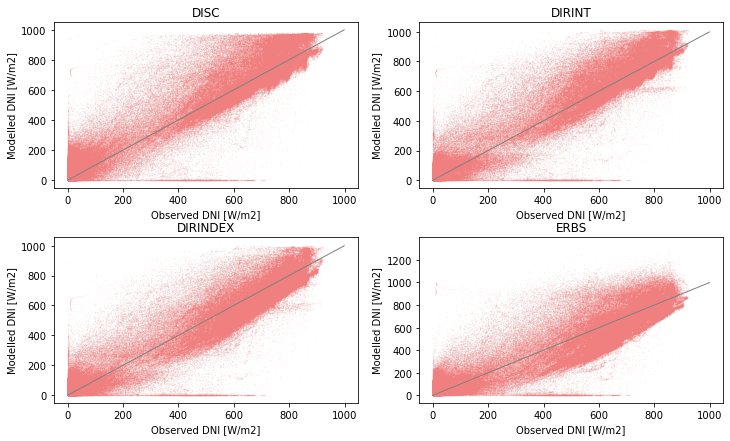

In [2]:
#%%
"""Question 1"""

###SUB-QUESTION 1.1
#Calculate the DNI based on four models
#First load the data set and solar angles for Utrecht
Utrecht_data = load_location_and_solar_angles('Utrecht')

#Then for loop through the models to get the DNI values and error functions
for model in MODELS:
    modelled_dni_utrecht = find_dni(model, 'Utrecht')[model+"_DNI"]
    compare_dni(model, Utrecht_data.DNI, modelled_dni_utrecht)


###SUB-QUESTION 1.3
scatter_modelled_dnis = create_utrecht_dni_scatters()

'best is 135 orientation, 30 tilt for A, and 20 tilt for B\n\nseems  plausible since when you compare RoofB with SurfaceCS and SurfaceBS (all same orientation):\nRoofB - tilt 20 - POA at 12.00 = 38\nRoofCS - tilt 40 - POA at 12.00 = 35\nSurface BS - tilt 90 - POA at 12.00 = 24'

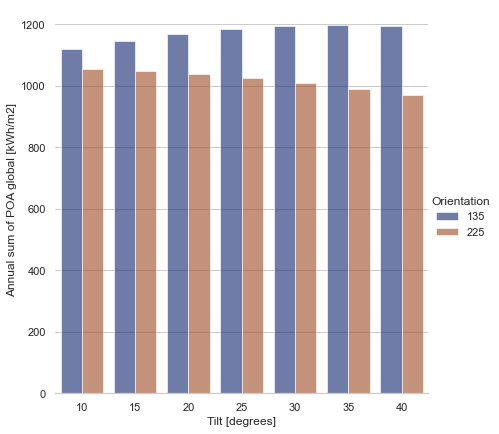

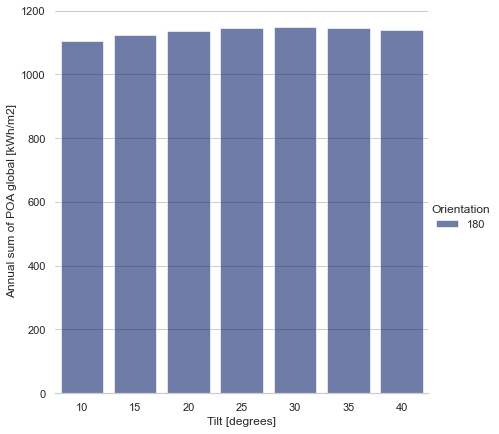

In [3]:
"""Question 2"""

#the data prep steps are in the load_location_and_solar_angles() function, which gets called as part of the find_dni function. See lines 64-76 of functions script
Eind_data = find_dni('dirindex','Eindhoven') 

#DICTIONARY in the global variables list, made it into a dataframe here to manipulate
BUILDINGS_df = pd.DataFrame(BUILDINGS)

###SUB-QUESTION 2.3 - get the POA data in one big dataframe, then manipulate the dataframe to get just the 3 POA dfs we want
all_surface_POA_data = create_surfaces_POAs('dirindex', "Eindhoven", BUILDINGS_df)

POA_direct = all_surface_POA_data.loc[:,[x for x in all_surface_POA_data.columns if "direct" in x]]
POA_diffuse = all_surface_POA_data.loc[:,[x for x in all_surface_POA_data.columns if "diffuse" in x]]
#note POA_total = POA_global
POA_total = all_surface_POA_data.loc[:,[x for x in all_surface_POA_data.columns if "global" in x]]

###SUB-QUESTION 2.4
#surfaces to calculate is a dictionary of the roof A and B tilts and orientations to loop through
POA_sums_RoofA_and_B = calculate_optimal_angles('dirindex', 'Eindhoven', SURFACES_TO_CALCULATE)
create_bar_charts('RoofA')
create_bar_charts('RoofB')

###SUB-QUESTION 2.5
#this function filters the POA table by Roof A only
POA_sums_RoofA = POA_sums_RoofA_and_B.loc[lambda df: df['surface'] == "RoofA" ]
POA_sums_RoofA
# return the row with the highest POA value of the Roof A POAs
max_a_row = POA_sums_RoofA.iloc[POA_sums_RoofA['sum of POA global'].idxmax(axis=0)]
max_a_row['tilt']
max_a_row['orientation']

#filter by roof B
POA_sums_RoofB = POA_sums_RoofA_and_B.loc[lambda df: df['surface'] == "RoofB"]
POA_sums_RoofB['sum of POA global'].max()

# create a new DF of the optimum A and B tilts and orientations
AB = [[max_a_row['tilt'], 20], [max_a_row['orientation'],180]]
ABdf = pd.DataFrame(data = AB, index = ['tilt', 'orientation'], columns = ["RoofA", "RoofB"])

#merge the roofA and roof B tilts and orientations to the BUILDINGS_df, called it BUILDINGS_df_update
BUILDINGS_df = pd.DataFrame(BUILDINGS)
BUILDINGS_df_update =  BUILDINGS_df.merge(ABdf, left_index=True, right_index=True, how = 'left')
BUILDINGS_df_update

#now we make the POA tables again, with the new info for Roof A and Roof B
all_surface_POA_data = create_surfaces_POAs('dirindex', "Eindhoven", BUILDINGS_df_update)
all_surface_POA_data

POA_direct = all_surface_POA_data.loc[:,[x for x in all_surface_POA_data.columns if "direct" in x]]
POA_direct
POA_diffuse = all_surface_POA_data.loc[:,[x for x in all_surface_POA_data.columns if "diffuse" in x]]
POA_diffuse
POA_total = all_surface_POA_data.loc[:,[x for x in all_surface_POA_data.columns if "global" in x]]
POA_total

###SUB-QUESTION 2.6

# added a text string here of some ideas for this one, was quite lazy answering it, think we should add more
"""best is 135 orientation, 30 tilt for A, and 20 tilt for B

seems  plausible since when you compare RoofB with SurfaceCS and SurfaceBS (all same orientation):
RoofB - tilt 20 - POA at 12.00 = 38
RoofCS - tilt 40 - POA at 12.00 = 35
Surface BS - tilt 90 - POA at 12.00 = 24"""


In [24]:
POA_total.sum()

SurfaceASE_poa_global    9.639891e+05
SurfaceASW_poa_global    6.563875e+05
SurfaceBE_poa_global     8.518385e+05
SurfaceBS_poa_global     8.457529e+05
SurfaceBW_poa_global     5.268621e+05
RoofCS_poa_global        1.182941e+06
RoofCN_poa_global        7.532503e+05
RoofDW_poa_global        8.199197e+05
RoofDE_poa_global        1.154118e+06
RoofA_poa_global         1.259262e+06
RoofB_poa_global         1.179605e+06
dtype: float64

In [4]:
ModuleParameters

NameError: name 'ModuleParameters' is not defined

In [28]:
from pvlib.irradiance import get_total_irradiance,disc,dirint,dirindex,erbs,aoi
from pvlib.solarposition import ephemeris
from pvlib.atmosphere import get_relative_airmass,get_absolute_airmass
from pvlib.clearsky import lookup_linke_turbidity,ineichen
from pvlib.pvsystem import sapm_effective_irradiance, sapm
from pvlib.temperature import sapm_cell

def get_aoi(Surfaces_angles_areas:dict, location_data, surface):
    
    surface_tilt = Surfaces_angles_areas[surface]['tilt']
    surface_azimuth = Surfaces_angles_areas[surface]['orientation']
    solar_zenith =  location_data.zenith
    solar_azimuth = location_data.azimuth
    
    sr_aoi = aoi(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth)
    return sr_aoi

def get_sapm_effective(location_data, ModuleParameters, surface, module):
    
    poa_direct = location_data[surface+'_poa_direct']
    poa_diffuse = location_data[surface+'_poa_diffuse']
    airmass_absolute = location_data[surface+'_abs_airmass']
    aoi = location_data[surface+'_aoi']
    module = ModuleParameters[module]
    
    sapm_parameters = sapm_effective_irradiance(poa_direct, poa_diffuse, airmass_absolute, aoi, module)
    return sapm_parameters

def get_sapm_cell(location_data, ModuleParameters, surface, module):
    
    poa_global = location_data[surface+'_poa_global']
    temp_air = location_data.temp
    wind_speed = location_data.wind
    a =  ModuleParameters[module]['A']
    b =  ModuleParameters[module]['B']
    deltaT = ModuleParameters[module]['DTC']
    irrad_ref=1000.0
    
    sapm_cell_data = sapm_cell(poa_global, temp_air, wind_speed, a, b, deltaT, irrad_ref=1000.0)
    return sapm_cell_data     

###### FINAL FUNCTION FOR 3.2


def get_DC_output(location_data:pd.DataFrame, Surfaces_angles_areas:dict, all_surface_POA_data, surface, module):
    
    apparent_zenith = location_data.apparent_zenith
    #add the dhi, aoi to the location_data df.
    sr_aoi = get_aoi(Surfaces_angles_areas, location_data, surface) 
    sr_aoi.rename(surface+'_aoi', inplace = True)
    location_data = location_data.assign(dhi_from_dni = lambda df: df.ghi  - np.cos(np.deg2rad(df.zenith))*df.dirindex_DNI)
    location_data = location_data.merge(sr_aoi, left_index=True, right_index=True, how= 'left')
    
    # and relative and abs airmass
    location_data[surface+'_rel_airmass'] = get_relative_airmass(apparent_zenith)
    location_data[surface+'_abs_airmass'] =  get_absolute_airmass(location_data[surface+'_rel_airmass'])
    
    #add the POA data previously defined
    location_data = location_data.merge(all_surface_POA_data.loc[:,[x for x in all_surface_POA_data.columns if surface in x]], left_index=True, right_index=True, how= 'left')
    
    #add the SAPM Effective Irradiance Output
    sapm_eff_irr = (get_sapm_effective(location_data, ModuleParameters, surface, module))
    location_data[surface+'_SAPM_eff_irr'] = sapm_eff_irr
    
    #add the SAPM Cell info
    sapm_celltemp = get_sapm_cell(location_data, ModuleParameters, surface, module)
    location_data[surface+'_SAPM_cell_temp'] = sapm_celltemp
    
    #calculate the power output
    effective_irradiance =  location_data[surface+'_SAPM_eff_irr']
    temp_cell = location_data[surface+'_SAPM_cell_temp']
    module = ModuleParameters[module]
    power_df = sapm(effective_irradiance, temp_cell, module)   
    
    location_data[surface+'_p_mp'] = power_df['p_mp']
    
    return location_data




,Best Module,Total Capacity,Tilt,Orientation
Surface,,,,
SurfaceASE,Mono Si,3360,90,135
SurfaceASW,Mono Si,2800,90,225
SurfaceBE,Mono Si,280,90,90
SurfaceBS,Mono Si,840,90,180
SurfaceBW,Mono Si,280,90,270
RoofCS,Mono Si,280,40,180
RoofCN,Mono Si,280,40,0
RoofDW,Mono Si,280,40,270
RoofDE,Mono Si,280,40,90


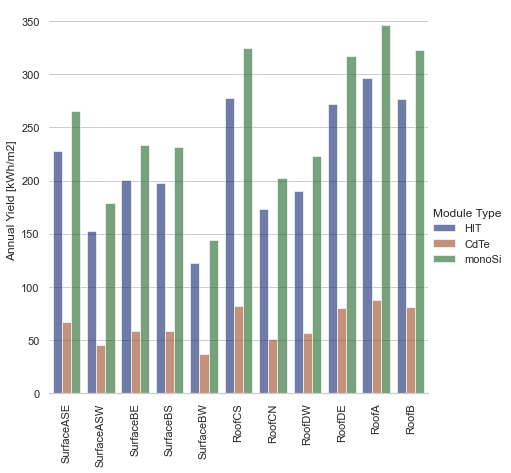

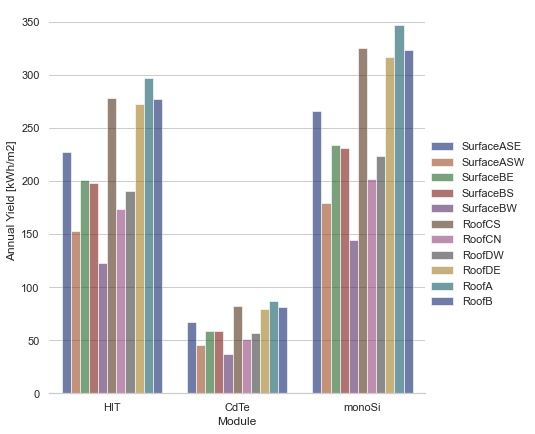

In [29]:
p_mp_values = pd.DataFrame(index = Eind_data.index)

for surface in Surfaces_angles_areas.columns:
    for module in ['HIT', 'CdTe', 'monoSi']:
        module_dc = get_DC_output(Eind_data, Surfaces_angles_areas, all_surface_POA_data, surface, module)

        p_mp_values[module+surface+'_p_mp'] = module_dc[surface+'_p_mp']

p_mp_sums = p_mp_values.sum(axis=0)

module_yields = pd.DataFrame(columns = ['surface','module','annualyield' ])

module_yields['surface'] = BUILDINGS_df_update.columns.repeat(3)
module_yields['module'] = ['HIT','CdTe', 'monoSi']*11
module_yields['annualyield'] = p_mp_sums.values/1000

def create_bar_charts_DC_outputs_surface_groups(module_yields):
    
    sns.set_theme(style="whitegrid")
    
    # Draw a nested barplot by tilt and orientation
    g = sns.catplot(
        data = module_yields, kind="bar",
        x="surface", y="annualyield", hue="module",
        ci = None, palette="dark", alpha=0.6, height=6,
    )
    g.despine(left=True)
    g.set_axis_labels('', "Annual Yield [kWh/m2]")
    g.legend.set_title('Module Type')
    g.set_xticklabels(rotation=90)
    
create_bar_charts_DC_outputs_surface_groups(module_yields)

def create_bar_charts_DC_outputs_module_groups(module_yields):
    
    sns.set_theme(style="whitegrid")
    
    # Draw a nested barplot by tilt and orientation
    g = sns.catplot(
        data = module_yields, kind="bar",
        x="module", y="annualyield", hue="surface",
        ci = None, palette="dark", alpha=.6, height=6
    )
    g.despine(left=True)
    g.set_axis_labels("Module", "Annual Yield [kWh/m2]")
    g.legend.set_title(' ')
    
create_bar_charts_DC_outputs_module_groups(module_yields)

def get_PV_systems_table(BUILDINGS_df_update, Surfaces_Panel_info):
    
    df = pd.DataFrame(columns = ['Surface', 'Best Module', 'Total Capacity', 'Tilt', 'Orientation'])
    df['Surface'] = BUILDINGS_df_update.columns
    df['Best Module'] = ('Mono Si')
    Surfaces_Panel_info_transposed = Surfaces_Panel_info.transpose()
    df['Total Capacity'] = Surfaces_Panel_info_transposed['Capacity_monoSi'].values.astype(int) 
    df['Tilt'] = Surfaces_Panel_info_transposed['tilt'].values.astype(int) 
    df['Orientation'] = Surfaces_Panel_info_transposed['orientation'].values.astype(int) 
    df.set_index('Surface', inplace = True )

    return df

get_PV_systems_table(BUILDINGS_df_update, Surfaces_Panel_info)

In [30]:
Areas = pd.DataFrame(Surfaces_angles_areas.loc['Area']).transpose()
Areas

,SurfaceASE,SurfaceASW,SurfaceBE,SurfaceBS,SurfaceBW,RoofCS,RoofCN,RoofDW,RoofDE,RoofA,RoofB
Area,1800.0,1500.0,270.0,450.0,270.0,140.02,140.02,140.02,140.02,1500.0,750.0


In [31]:
Areas = pd.DataFrame(Surfaces_angles_areas.loc['Area']).transpose()
Areas
monosi_dcs = [x for x in p_mp_values.columns if "monoSi" in x]
monosi_dcs_table = p_mp_values[monosi_dcs]
monosi_dcs_table

total_facade_generation = monosi_dcs_table.multiply(np.array(Areas), axis='columns')
total_facade_generation

,monoSiSurfaceASE_p_mp,monoSiSurfaceASW_p_mp,monoSiSurfaceBE_p_mp,monoSiSurfaceBS_p_mp,monoSiSurfaceBW_p_mp,monoSiRoofCS_p_mp,monoSiRoofCN_p_mp,monoSiRoofDW_p_mp,monoSiRoofDE_p_mp,monoSiRoofA_p_mp,monoSiRoofB_p_mp
datetime,,,,,,,,,,,
2019-01-01 10:30:00+01:00,12222.548737,10185.457281,1833.382311,3055.637184,1833.382311,1448.114356,1448.114356,1448.114356,1448.114356,15513.294772,8368.247548
2019-01-01 11:30:00+01:00,9476.686487,7897.238739,1421.502973,2369.171622,1421.502973,1128.228460,1128.228460,1128.228460,1128.228460,12086.435438,6525.071454
2019-01-01 12:30:00+01:00,11227.055780,9355.879817,1684.058367,2806.763945,1684.058367,1332.443643,1332.443643,1332.443643,1332.443643,14274.142730,7701.964526
2019-01-01 13:30:00+01:00,19590.171464,16325.142886,2938.525720,4897.542866,2938.525720,2301.968474,2301.968474,2301.968474,2301.968474,24660.425022,13283.329198
2019-01-01 14:30:00+01:00,14083.092451,11735.910376,2112.463868,3520.773113,2112.463868,1664.136578,1664.136578,1664.136578,1664.136578,17827.487980,9612.145204
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 11:30:00+01:00,229960.704034,113504.966020,13587.298263,61505.841134,5557.510451,16975.469298,3697.757937,3697.757937,9286.433336,172287.701295,68574.084443
2019-12-31 12:30:00+01:00,45860.965366,37073.019047,4790.282727,12765.575290,4760.957257,4906.646521,3634.533661,3791.390580,3891.342565,49595.356448,25474.004592
2019-12-31 13:30:00+01:00,18042.042531,15035.035442,2706.306380,4510.510633,2706.306380,2119.406051,2119.406051,2119.406051,2119.406051,22704.678451,12229.189471


# REDO GRAPH PER FACADE


,Best Module,Total Capacity,Tilt,Orientation
Surface,,,,
SurfaceASE,Mono Si,3360,90,135
SurfaceASW,Mono Si,2800,90,225
SurfaceBE,Mono Si,280,90,90
SurfaceBS,Mono Si,840,90,180
SurfaceBW,Mono Si,280,90,270
RoofCS,Mono Si,280,40,180
RoofCN,Mono Si,280,40,0
RoofDW,Mono Si,280,40,270
RoofDE,Mono Si,280,40,90


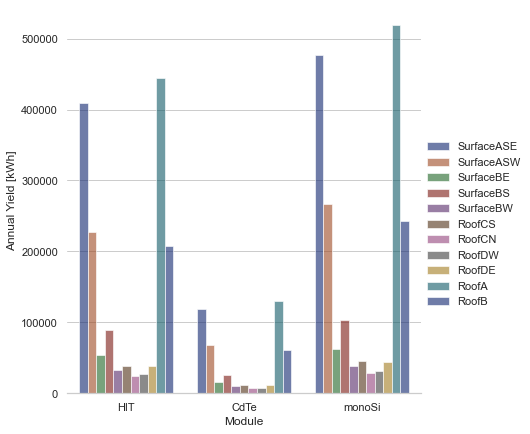

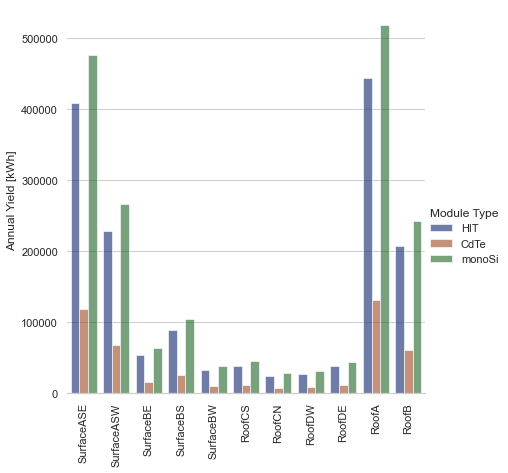

In [40]:
def whole_facade_tables_charts(Eind_data):
    p_mp_values_wholefacade = pd.DataFrame(index = Eind_data.index)

    for surface in Surfaces_angles_areas.columns:
        for module in ['HIT', 'CdTe', 'monoSi']:
            module_dc = get_DC_output(Eind_data, Surfaces_angles_areas, all_surface_POA_data, surface, module)

            p_mp_values[module+surface+'_p_mp'] = module_dc[surface+'_p_mp']

    p_mp_sums = p_mp_values.sum(axis=0)

    module_yields = pd.DataFrame(columns = ['surface','module','Annual Yield [kW/m2]' ])

    module_yields['surface'] = BUILDINGS_df_update.columns.repeat(3)
    module_yields['module'] = ['HIT','CdTe', 'monoSi']*11
    module_yields['Annual Yield [kW/m2]'] = (p_mp_sums.values/1000).astype(int)

    Area_series = (Surfaces_angles_areas.loc['Area']).repeat(3)
    Area_series.values

    module_yields['Areas [m2]'] = Area_series.values.astype(int)
    module_yields['Yield, Whole Facade [kW]'] = module_yields['Annual Yield [kW/m2]']*module_yields['Areas [m2]'].astype(int)
    return module_yields

def create_bar_charts_DC_outputs_surface_groups_whole(module_yields):
    
    sns.set_theme(style="whitegrid")
    
    # Draw a nested barplot by tilt and orientation
    g = sns.catplot(
        data = module_yields, kind="bar",
        x="surface", y="Yield, Whole Facade [kW]", hue="module",
        ci = None, palette="dark", alpha=0.6, height=6,
    )
    g.despine(left=True)
    g.set_axis_labels('', "Annual Yield [kWh]")
    g.legend.set_title('Module Type')
    g.set_xticklabels(rotation=90)

def create_bar_charts_DC_outputs_module_groups_whole(module_yields):
    
    sns.set_theme(style="whitegrid")
    
    # Draw a nested barplot by tilt and orientation
    g = sns.catplot(
        data = module_yields, kind="bar",
        x="module", y="Yield, Whole Facade [kW]", hue="surface",
        ci = None, palette="dark", alpha=.6, height=6
    )
    g.despine(left=True)
    g.set_axis_labels("Module", "Annual Yield [kWh]")
    g.legend.set_title(' ')


def get_PV_systems_table(BUILDINGS_df_update, Surfaces_Panel_info):
    
    df = pd.DataFrame(columns = ['Surface', 'Best Module', 'Total Capacity', 'Tilt', 'Orientation'])
    df['Surface'] = BUILDINGS_df_update.columns
    df['Best Module'] = ('Mono Si')
    Surfaces_Panel_info_transposed = Surfaces_Panel_info.transpose()
    df['Total Capacity'] = Surfaces_Panel_info_transposed['Capacity_monoSi'].values.astype(int) 
    df['Tilt'] = Surfaces_Panel_info_transposed['tilt'].values.astype(int) 
    df['Orientation'] = Surfaces_Panel_info_transposed['orientation'].values.astype(int) 
    df.set_index('Surface', inplace = True )

    return df

module_yields_whole_facade = whole_facade_tables_charts(Eind_data)
module_yields_whole_facade
create_bar_charts_DC_outputs_module_groups_whole(module_yields)
create_bar_charts_DC_outputs_surface_groups_whole(module_yields)
PV_table = get_PV_systems_table(BUILDINGS_df_update, Surfaces_Panel_info)
PV_table 

